In [141]:
import csv
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from mlxtend.frequent_patterns import fpgrowth
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from nltk.tag.perceptron import PerceptronTagger
import seaborn as sns
sns.set()
#nltk.download('averaged_perceptron_tagger')

In [2]:
pd.options.display.max_columns = 10

In [142]:
def kmeans(X,k=10,max_iterations=100):
    if isinstance(X, pd.DataFrame):X = X.values
    idx = np.random.choice(len(X), k, replace=False)
    centroids = X[idx, :]
    P = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
    for _ in range(max_iterations):
        centroids = np.vstack([X[P==i,:].mean(axis=0) for i in range(k)])
        tmp = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
        if np.array_equal(P,tmp):break
        P = tmp
    return P




def tokenize(phrase):
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub("\S*\d\S*", "", phrase).strip()
        phrase = re.sub('[^A-Za-z]+', ' ', phrase)
        phrase = re.sub(r"http\S+", "", phrase)
        phrase = BeautifulSoup(phrase, 'lxml').get_text()
        phrase = phrase.lower()                 # Converting to lowercase
        cleanr = re.compile('<.*?>')
        phrase = re.sub(cleanr, ' ', phrase)        #Removing HTML tags
        phrase = re.sub(r'[?|!|\'|"|#]',r'',phrase)
        phrase = re.sub(r'[.|,|)|(|\|/]',r' ',phrase)
        return [lemmatizer.lemmatize(token.strip()) for token in word_tokenize(phrase) if token not in stopwords and len(token) > 2]
    
def get_noun(text):
    tags = tagger.tag(text)
    return [token for token,tag in tags if tag in ('NN','NNS','NNP','NNPS')]

def generate_wordclouds_mine(X, in_X_tfidf, k, in_word_positions,word):

    # Clustering
    
    in_y_pred = kmeans(X)
    print('Clustering finished')
    in_cluster_ids = set(in_y_pred)
#     silhouette_avg = silhouette_score(X, in_y_pred)
#     print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    # Number of words with highest tfidf score to display
    top_count = 100
    if word == True:
        for in_cluster_id in in_cluster_ids:
            # compute the total tfidf for each term in the cluster
            in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
            # numpy.matrix
            tfidf_sum = np.sum(in_tfidf, axis=0)
            # numpy.array of shape (1, X.shape[1])
            tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
            top_indices = tfidf_sum.argsort()[-top_count:]
            term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
            wc = WordCloud(width=1200, height=800, background_color="white")
            wordcloud = wc.generate_from_frequencies(term_weights)
            fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis("off")
            fig.suptitle(f"Cluster {in_cluster_id}")
            plt.show()

    return in_y_pred
    
def generate_wordclouds_sklearn(X, in_X_tfidf, k, in_word_positions,word):

    # Clustering
    in_model = KMeans(n_clusters=k,init='k-means++', max_iter=300, n_init=10, random_state=0,n_jobs = -1)
    in_y_pred = in_model.fit_predict(X)
    print('Clustering finished')
    in_cluster_ids = set(in_y_pred)
#     silhouette_avg = silhouette_score(X, in_y_pred)
#     print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    # Number of words with highest tfidf score to display
    top_count = 100
    if word == True:
        for in_cluster_id in in_cluster_ids:
            # compute the total tfidf for each term in the cluster
            in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
            # numpy.matrix
            tfidf_sum = np.sum(in_tfidf, axis=0)
            # numpy.array of shape (1, X.shape[1])
            tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
            top_indices = tfidf_sum.argsort()[-top_count:]
            term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
            wc = WordCloud(width=1200, height=800, background_color="white")
            wordcloud = wc.generate_from_frequencies(term_weights)
            fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis("off")
            fig.suptitle(f"Cluster {in_cluster_id}")
            plt.show()

    return in_y_pred

def elbow_method(x_svd,n,step):
    wcss = []
    for i in range(step, n+1,step):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(x_svd)
        wcss.append(kmeans.inertia_)
        print('kmeans with {} clusters finished'.format(i))
    plt.plot(range(0, len(wcss)), wcss,'bx-')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    return wcss

In [5]:
df = pd.read_csv('dataset/reviews.csv')
df = df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
df.shape

(393933, 10)

In [6]:
tagger = PerceptronTagger()
lemmatizer = WordNetLemmatizer()

In [15]:
df['tokenized_text'] = df["Text"].apply(tokenize)

In [22]:
df['tokenized_text_noun'] = df['tokenized_text'].apply(get_noun)

In [36]:
stopwords = set(stopwords.words('english')) 
vectorizer = TfidfVectorizer(min_df=.01, max_df=.90)
X_tfidf = vectorizer.fit_transform(df.tokenized_text_noun.apply(lambda x: ' '.join(x)))
print(X_tfidf.shape)

(393933, 262)


In [101]:
#Dimensionality reduction with Linear Semantic Analysis
svd = TruncatedSVD(n_components=X_tfidf.shape[1]-1, random_state=42) 
lsa = svd.fit(X_tfidf)
X_svd = svd.fit_transform(X_tfidf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 1.00


In [97]:
exp_variance = pd.DataFrame(enumerate(np.cumsum(svd.explained_variance_ratio_)))
print("n_components with 60% of variance explained:",exp_variance[exp_variance[1]>=0.6][0].head(1).item())
del exp_variance

n_components with 60% of variance explained: 85


In [103]:
terms = vectorizer.get_feature_names() 
for ind,comp in enumerate(lsa.components_):
    termsInComp = zip(terms,comp)
    sortedTerms = sorted(termsInComp, key=lambda x: x[1],reverse=True)[:7]
    print("Concept %d" % ind)
    for term in sortedTerms:
        print(term[0])
    print(" ")

Concept 0
coffee
product
taste
tea
flavor
price
time
 
Concept 1
coffee
cup
roast
starbucks
maker
morning
machine
 
Concept 2
tea
cup
flavor
drink
coffee
leaf
bag
 
Concept 3
dog
food
treat
cat
coffee
tea
love
 
Concept 4
product
tea
coffee
price
order
amazon
cup
 
Concept 5
flavor
price
store
order
amazon
box
time
 
Concept 6
flavor
dog
product
taste
treat
water
coffee
 
Concept 7
food
cat
taste
flavor
brand
sauce
water
 
Concept 8
chocolate
food
bar
cat
product
tea
milk
 
Concept 9
price
chocolate
taste
food
flavor
store
bar
 
Concept 10
water
use
price
cup
oil
chocolate
mix
 
Concept 11
love
sugar
treat
snack
use
cat
store
 
Concept 12
bag
box
cup
snack
sugar
chip
size
 
Concept 13
price
cat
treat
bag
time
cup
water
 
Concept 14
bar
snack
sugar
time
price
food
candy
 
Concept 15
bag
love
time
use
oil
chip
price
 
Concept 16
cup
box
love
order
food
price
dog
 
Concept 17
order
oil
use
day
bar
candy
coconut
 
Concept 18
oil
box
use
sauce
bar
brand
treat
 
Concept 19
cup
bar
order
stor

In [44]:
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}

kmeans with 1 clusters finished
kmeans with 2 clusters finished
kmeans with 3 clusters finished
kmeans with 4 clusters finished
kmeans with 5 clusters finished
kmeans with 6 clusters finished
kmeans with 7 clusters finished
kmeans with 8 clusters finished
kmeans with 9 clusters finished
kmeans with 10 clusters finished
kmeans with 11 clusters finished
kmeans with 12 clusters finished
kmeans with 13 clusters finished
kmeans with 14 clusters finished
kmeans with 15 clusters finished
kmeans with 16 clusters finished
kmeans with 17 clusters finished
kmeans with 18 clusters finished
kmeans with 19 clusters finished
kmeans with 20 clusters finished


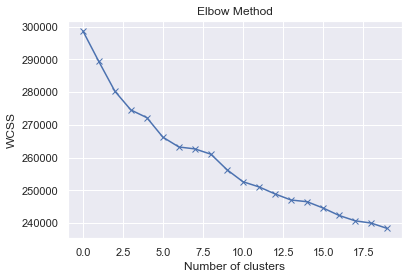

In [98]:
wcss = elbow_method(X_svd[:,0:150],20,1)

## kmeans implementation from scratch

Clustering finished
[9 9 8 ... 2 2 9]


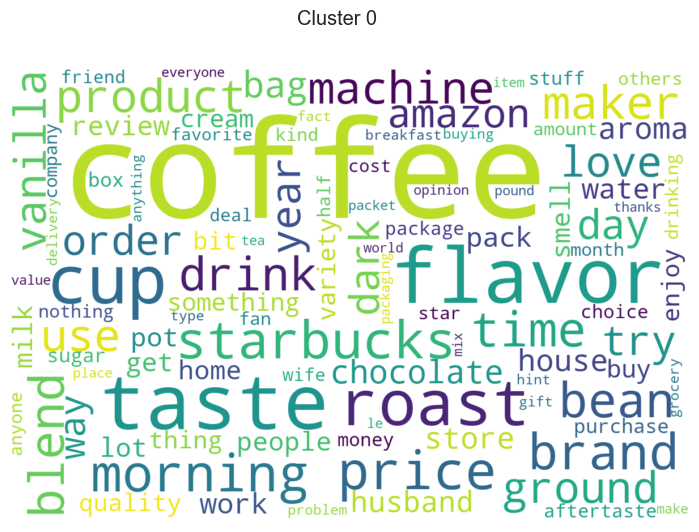

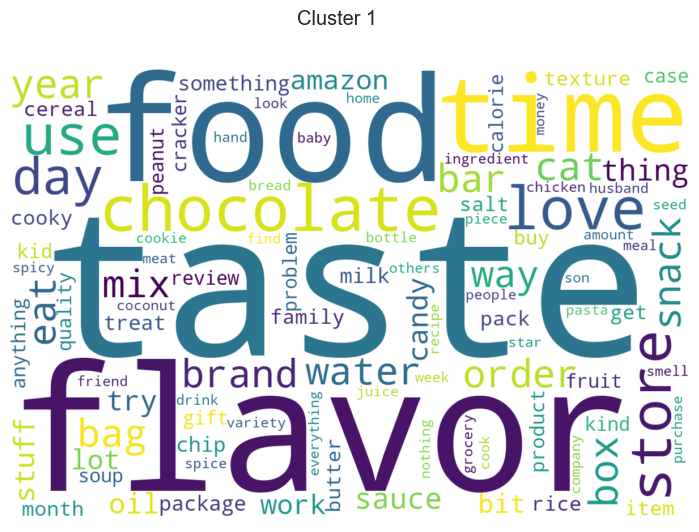

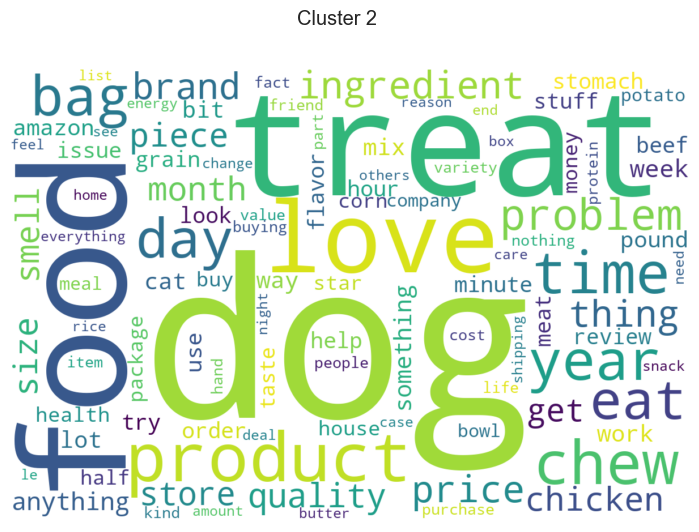

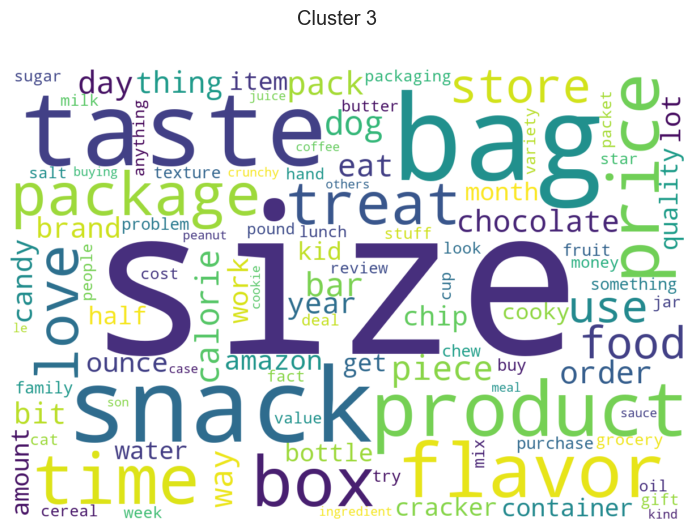

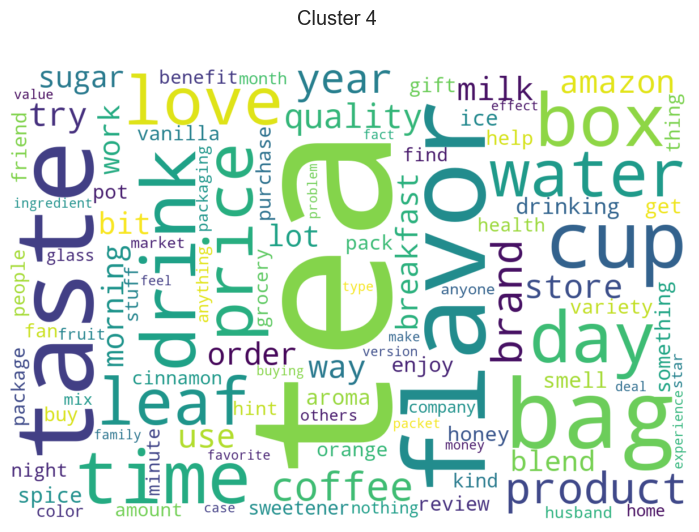

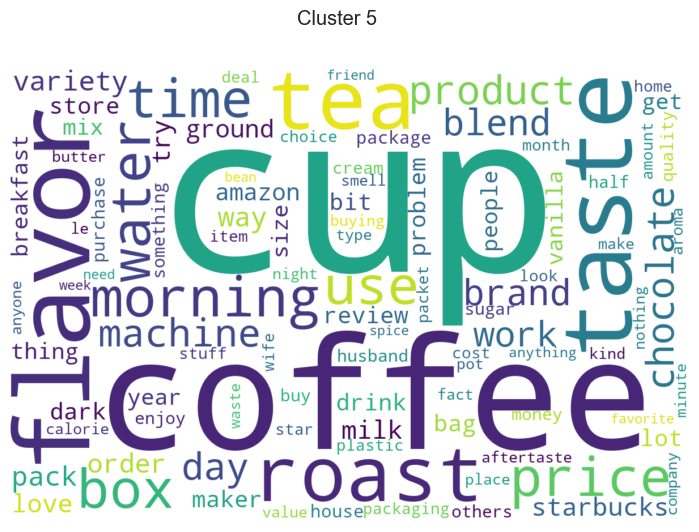

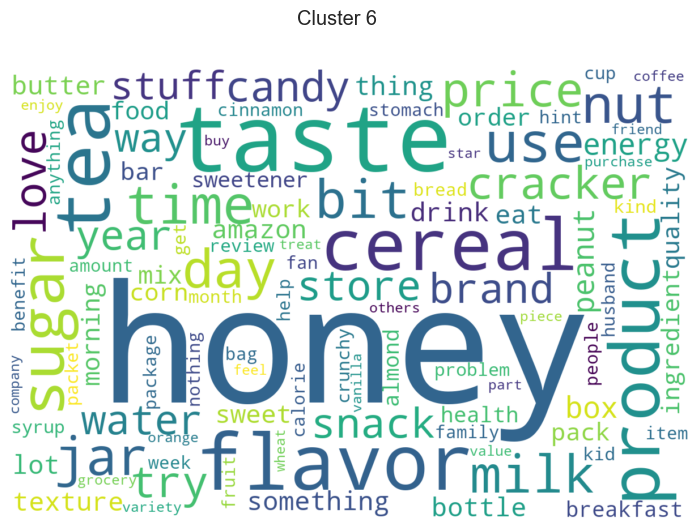

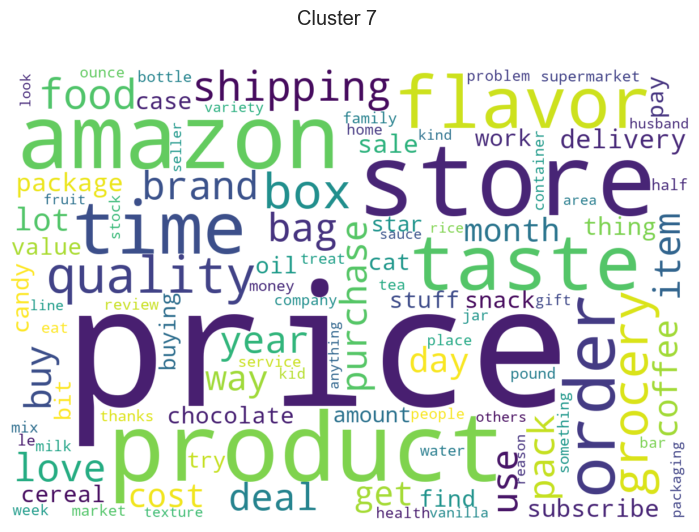

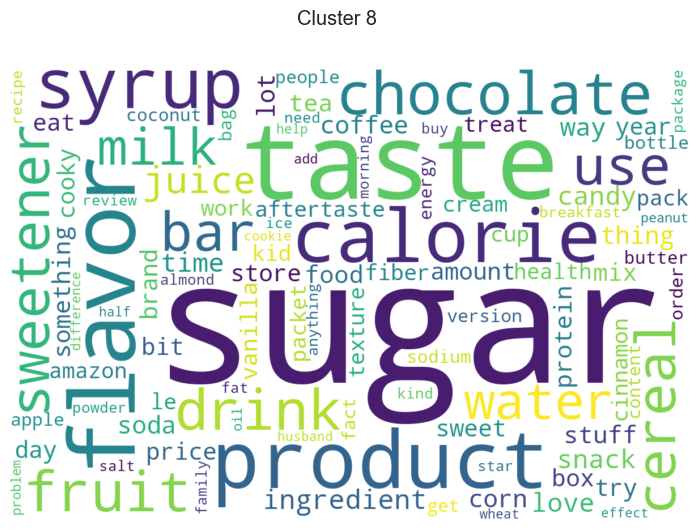

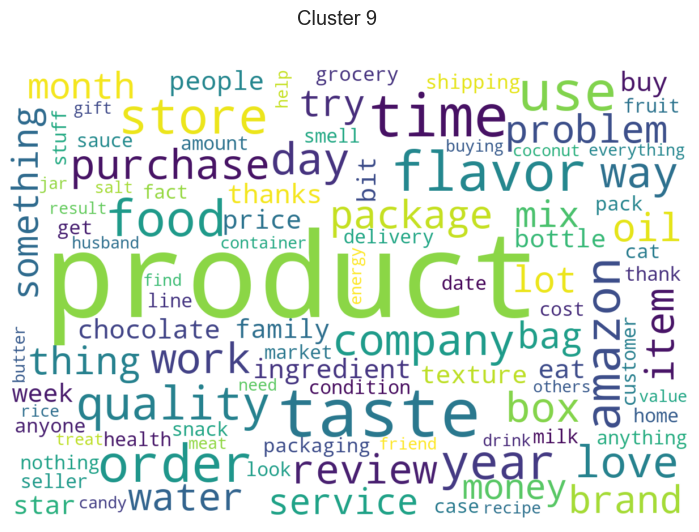

array([9, 9, 8, ..., 2, 2, 9], dtype=int64)

In [145]:
generate_wordclouds_mine(X_svd[:,0:85], X_tfidf, 10, word_positions,True)

## Sklearn kmeans ++ implementation

Clustering finished


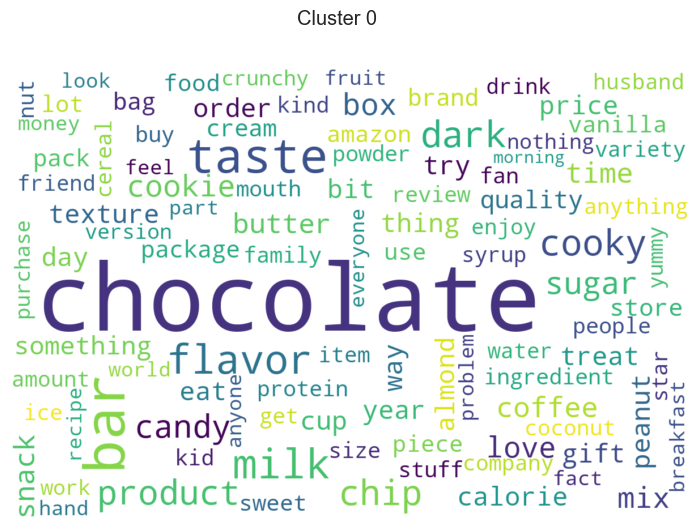

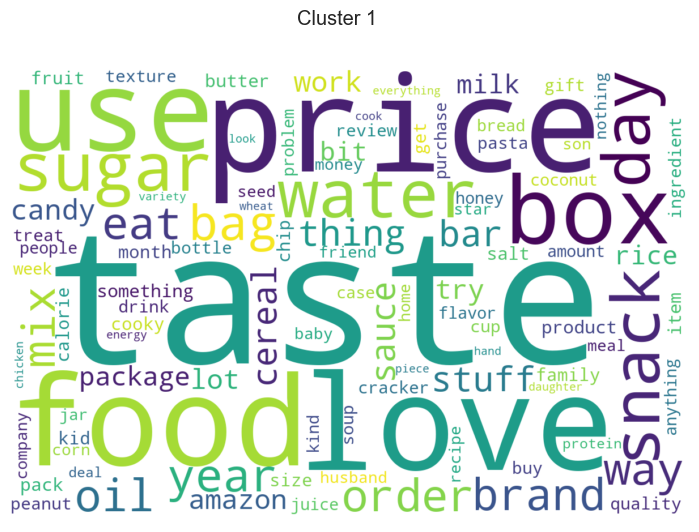

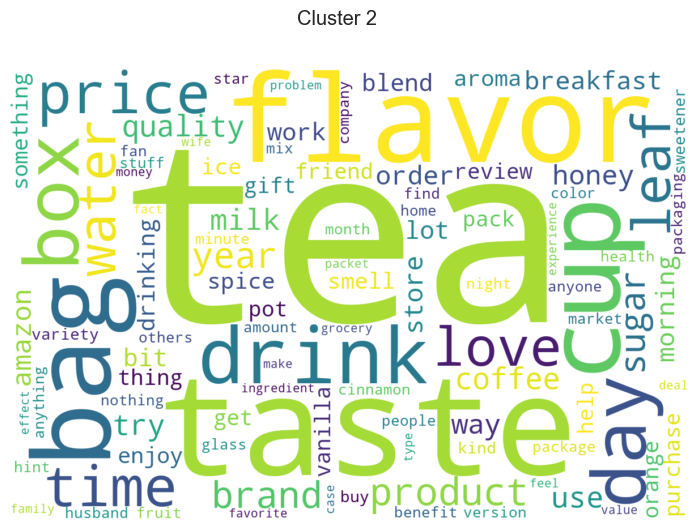

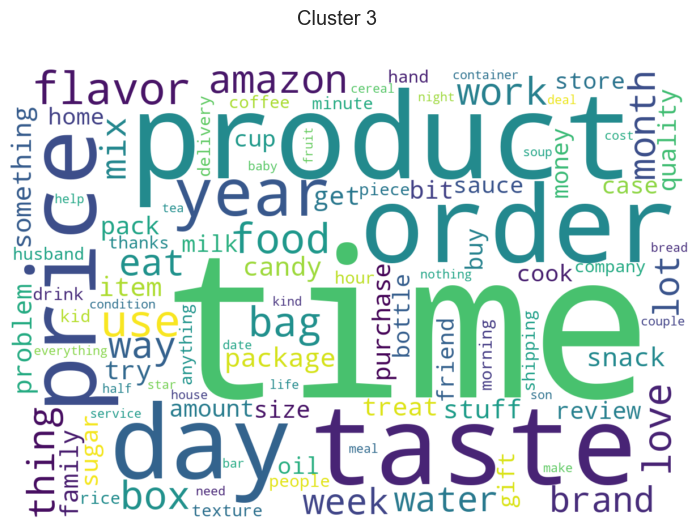

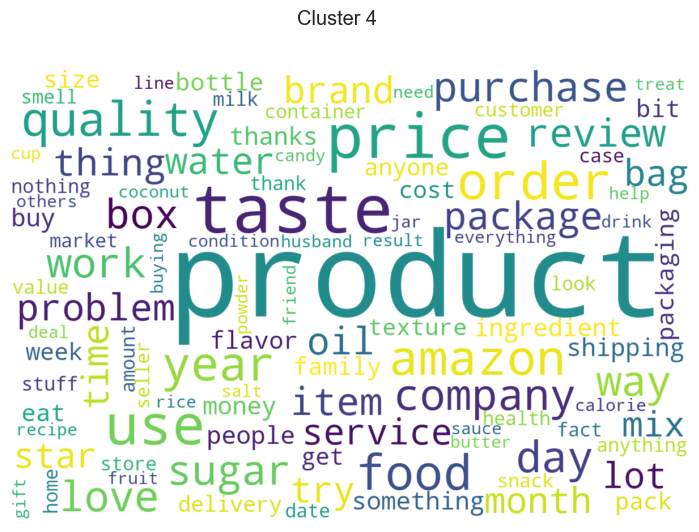

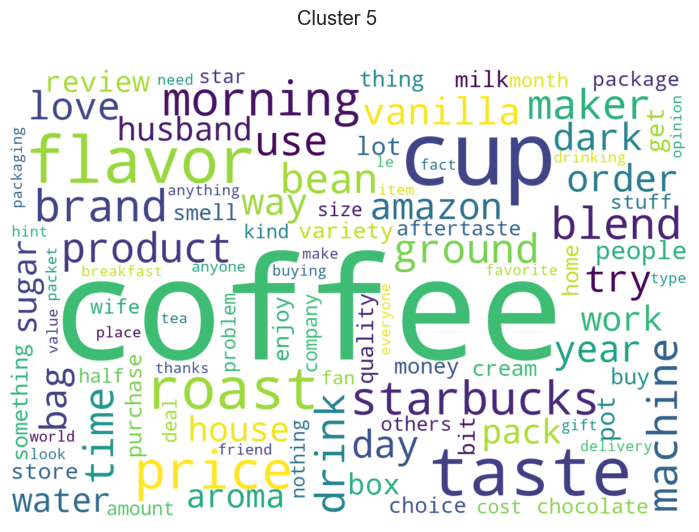

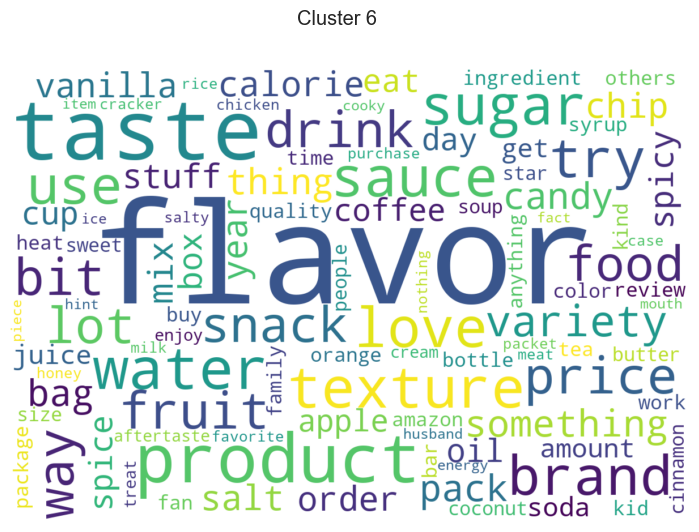

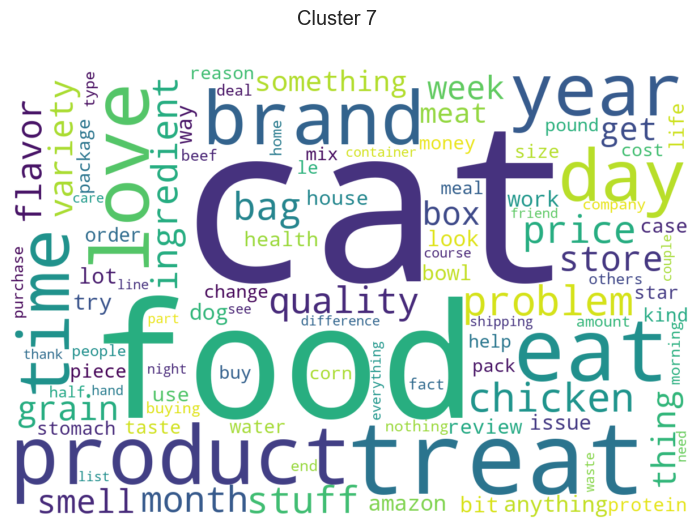

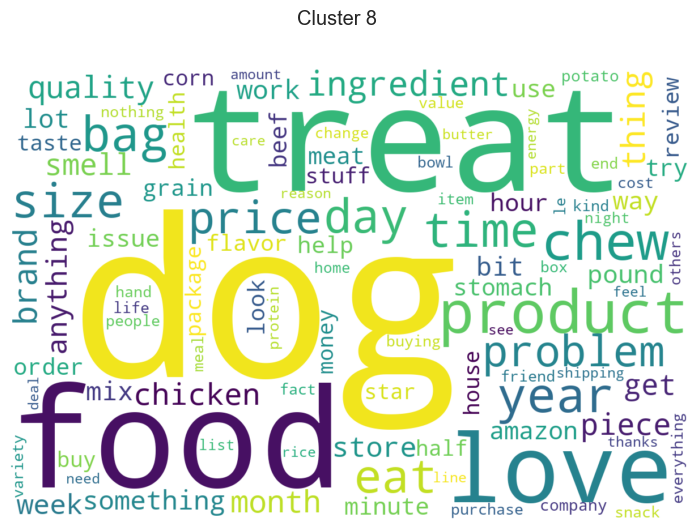

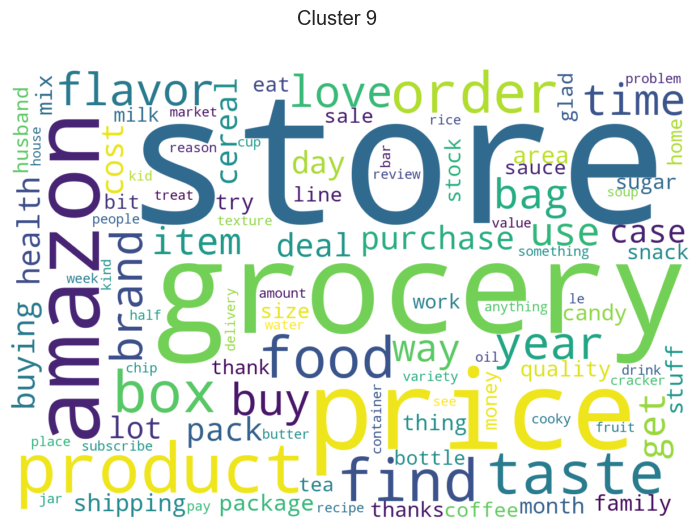

In [105]:
df["Cluster"] = generate_wordclouds(X_svd[:,0:85], X_tfidf, 10, word_positions,True)

## Provide the number of product for each cluster

In [107]:
df.groupby('Cluster')['ProductId'].nunique()

Cluster
0     5416
1    44254
2     5655
3    14234
4    17841
5     5144
6    15243
7     2189
8     4158
9    13074
Name: ProductId, dtype: int64

## Compute Score Distribution for each cluster and test mean difference significance

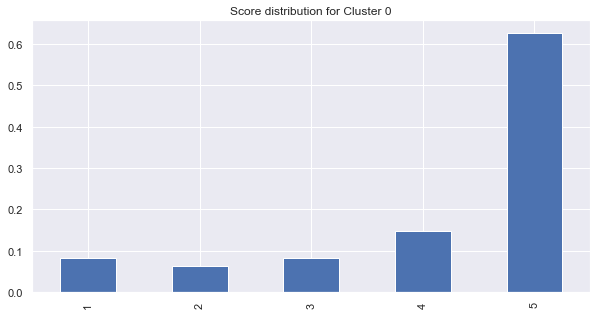

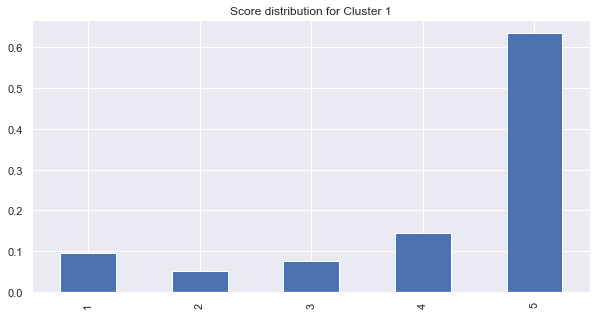

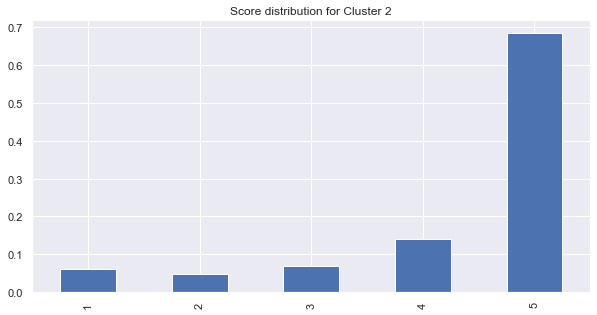

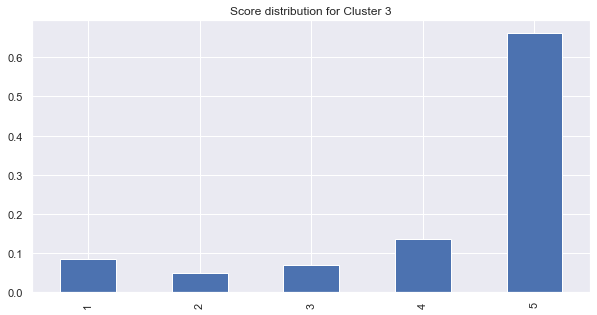

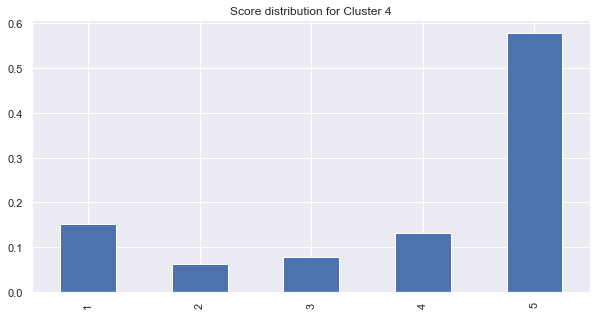

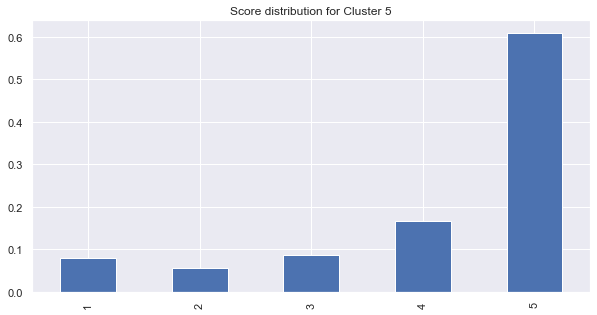

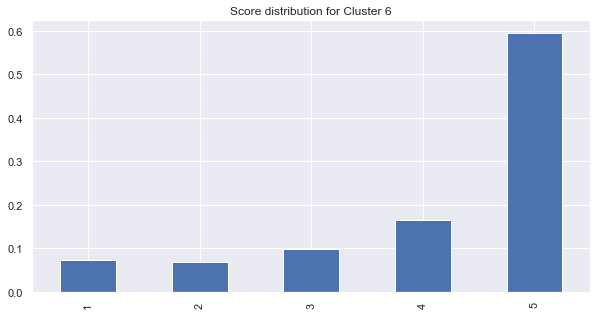

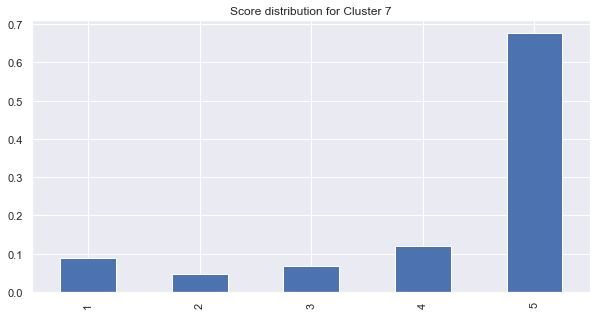

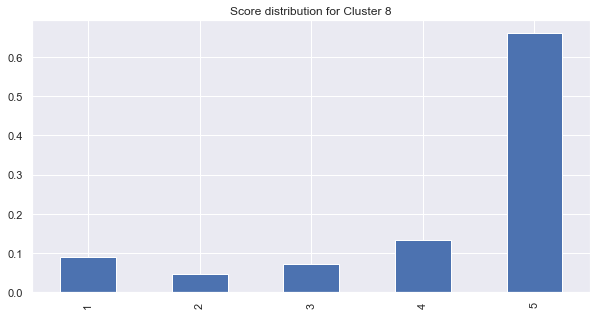

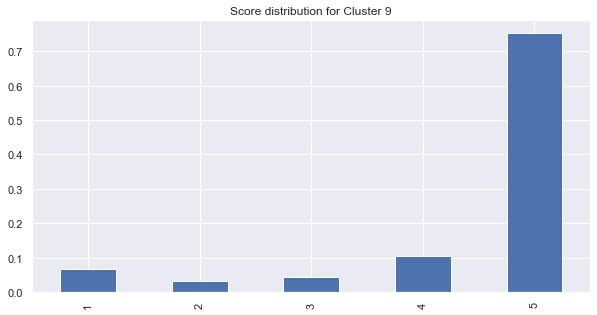

In [108]:
for i in range(0,10):
    plt.figure(figsize = (10,5))
    df[df.Cluster == i].Score.value_counts(normalize = True,).sort_index().plot(kind = 'bar').set_title('Score distribution for Cluster {}'.format(i))   

In [109]:
df.groupby('Cluster')['Score'].agg(['mean','std'])

mean       std
Cluster                    
0        4.174216  1.288292
1        4.168338  1.322921
2        4.341372  1.168876
3        4.241176  1.277773
4        3.923793  1.501165
5        4.164697  1.273947
6        4.141707  1.263989
7        4.246065  1.293435
8        4.228755  1.292754
9        4.447440  1.147000

In [124]:
from scipy.stats import kruskal
stat, p = kruskal(df.Score[df.Cluster == 0].sample(1000), df.Score[df.Cluster == 1].sample(1000),df.Score[df.Cluster == 2].sample(1000),df.Score[df.Cluster == 3].sample(1000),df.Score[df.Cluster == 4].sample(1000),df.Score[df.Cluster == 5].sample(1000),df.Score[df.Cluster == 6].sample(1000),df.Score[df.Cluster == 7].sample(1000),df.Score[df.Cluster == 8].sample(1000),df.Score[df.Cluster == 9].sample(1000))
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=110.907, p=0.000
Different distributions (reject H0)


### Kruskal Test fail to Reject H0(all the cluster belong to same distribution). This means that at least one of the distribution differs from the others

In [119]:
df.groupby('Cluster')['UserId'].nunique()

Cluster
0     13933
1    125622
2     20033
3     23470
4     33249
5     25776
6     26620
7      7915
8     15854
9     20919
Name: UserId, dtype: int64

## Algorthmic question

In [181]:
def counting_sort(alist, largest):
    c = [0]*(largest + 1)
    for i in range(len(alist)): # N 
        c[alist[i]] = c[alist[i]] + 1
 
    # Find the last index for each element
    c[0] = c[0] - 1 
    for i in range(1, largest + 1): # r
        c[i] = c[i] + c[i - 1]
 
    result = [None]*len(alist)
 
    for x in reversed(alist):
        result[c[x]] = x
        c[x] = c[x] - 1
 
    return result
 
from time import time
alist = np.random.randint(1000,size = 10)
k = max(alist)
start = time()
sorted_list = counting_sort(alist, k)
print('Sorted list: ', end='')
print(sorted_list)
print(time() - start)

Sorted list: [1, 68, 117, 153, 420, 521, 532, 585, 737, 782]
0.010760307312011719


array([69, 36, 31, 95, 54, 59, 18, 25, 87, 87])